Case 3 - Drug Reviews
=====================
Henrik Hokkanen, Simo Mäkelä  
19.3.2020  
Neural Networks for Health Technology Applications  
Helsinki Metropolia University of Applied Sciences

Introduction
------------

In this exercise, the task is to build a system that can _predict numerical ratings from textual drug reviews_ written by patients. The dataset in use can be found at https://www.kaggle.com/jessicali9530/kuc-hackathon-winter-2018/home

The students are instructed to follow along the lines of [Gräßer, Kallumadi, Malberg and Zaunseder's research paper](http://kdd.cs.ksu.edu/Publications/Student/kallumadi2018aspect.pdf), which describes analysis of the same dataset using logistic regression. In this exercise, however, the students are instructed to use __one-dimensional convolutional neural networks__ or __recurrent neural networks__ or both, instead of logistic regression.

The aim is to learn about these technologies and __text processing__.

In [210]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#nltk.download()
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score

In [211]:
train = pd.read_csv('../input/kuc-hackathon-winter-2018/drugsComTrain_raw.csv')
test = pd.read_csv('../input/kuc-hackathon-winter-2018/drugsComTest_raw.csv')
#train = pd.read_csv('drugsComTrain_raw.csv')
#test = pd.read_csv('drugsComTest_raw.csv')

## The Data

We analyze the [UCI ML Drug Review dataset](https://www.kaggle.com/jessicali9530/kuc-hackathon-winter-2018), which contains over 200k drug reviews written by patients, along with 10-star numerical ratings. It contains the following features:

- `uniqueID`: Unique ID - _int_
- `drugName`: Name of drug - _string_
- `condition`: Name of condition - _string_
- `review`: Patient review - _string_
- `rating`: 10 star patient rating - _int_
- `date`: Date of review entry - _date_
- `usefulCount`: Number of users who found review useful - _int_

## The Problem
The problem is basically _sentiment analysis_ regarding overall patient satisfaction (_Gräßer, Kallumadi, et al. p. 123_). We reduce this to a task of __threefold classification__, deriving target classes from the 10-star rating:

- negative: _< 5 stars_
- neutral: _5 or 6 stars_
- positive: _> 6 stars_

## The Method
We have the choice between the two aforementioned methods, or both. Let's assess their suitability for this problem.

#### RNN

_"RNNs are designed to make use of sequential data, when the current step has some kind of relation with the previous steps. This makes them ideal for applications with a time component (audio, time-series data) and natural language processing. RNN’s perform very well for applications where sequential information is clearly important, because the meaning could be misinterpreted or the grammar could be incorrect if sequential information is not used. Applications include image captioning, language modeling and machine translation." ([Ghelani - Text Classification — RNN’s or CNN’s?](https://towardsdatascience.com/text-classification-rnns-or-cnn-s-98c86a0dd361))_

#### 1D Convnet

_"The result of each convolution will fire when a special pattern is detected. By varying the size of the kernels and concatenating their outputs, you’re allowing yourself to detect patterns of multiples sizes (2, 3, or 5 adjacent words). Patterns could be expressions (word ngrams?) like “I hate”, “very good” and therefore CNNs can identify them in the sentence regardless of their position. Based on the above explanation, the most natural fit for CNNs seem to be classifications tasks, such as Sentiment Analysis, Spam Detection or Topic Categorization." ([Ghelani - Text Classification — RNN’s or CNN’s?](https://towardsdatascience.com/text-classification-rnns-or-cnn-s-98c86a0dd361))_

#### Our Choice

In sentiment analysis, we are not overly concerned with long-range semantic dependency. Rather, we want to detect local key-phrases associated with a high or low rating. Therefore, the logical choice is to use a __convolutional neural network__, which is also much faster. ([Ghelani - Text Classification — RNN’s or CNN’s?](https://towardsdatascience.com/text-classification-rnns-or-cnn-s-98c86a0dd361))

## Preprocessing

Following the footsteps of Gräßer, Kallumadi, et al., we take the following preprocessing steps:

1. Convert everything to lowercase
2. Toss away all special chars, numbers and most punctuation
3. Tokenize on whitespace
4. No stopword removal
5. Instead, discard the most frequent tokens, and consider threshold frequency a hyperparameter
6. Convert review texts to a numeric feature space (integer sequences) using Keras

#### Points 1, 2 and 3:

In [212]:
# this takes care of points 1 to 3.
def tokenize_text(text):
    included_chars = [' ', '\t', '\n', "'", '-']
    
    text = ''.join(e for e in text if e.isalpha() or e in included_chars)
    tokens = text.split()
    tokens = [token.lower() for token in tokens if token.isalpha()]
    return tokens

In [213]:
texts = []
for review in train['review']:
    texts.append(tokenize_text(review))
texts = np.array(texts)

In [214]:
# test set
texts_test = []
for review in test['review']:
    texts_test.append(tokenize_text(review))
texts_test = np.array(texts_test)

In [215]:
print("Number of reviews:", len(texts))
print(texts[10][:50])

Number of reviews: 161297
['i', 'have', 'been', 'on', 'this', 'medication', 'almost', 'two', 'weeks', 'started', 'out', 'on', 'mg', 'and', 'working', 'my', 'way', 'up', 'to', 'mg', 'currently', 'at', 'mg', 'no', 'headaches', 'at', 'all', 'so', 'far', 'and', 'i', 'was', 'having', 'crippling', 'migraines', 'a', 'week', 'i', 'have', 'lost', 'lbs', 'so', 'far', 'but', 'note', 'i', 'am', 'really', 'paying', 'close']


#### Points 4 and 5:

Next, we find the __global frequency__ of each word, analyzing all the reviews in one lump:

In [216]:
%%time
all_words = []
for text in texts:
    all_words += text
freq = nltk.FreqDist(all_words)

CPU times: user 17.6 s, sys: 42 ms, total: 17.6 s
Wall time: 17.6 s


In [217]:
%%time
# the same for test set
all_words = []
for text in texts_test:
    all_words += text
freq_test = nltk.FreqDist(all_words)

CPU times: user 5.99 s, sys: 2.14 ms, total: 5.99 s
Wall time: 6.06 s


In [218]:
print("There are %d unique words in the reviews." % (len(freq)))

There are 66037 unique words in the reviews.


Let's look at the most common words to find a ballpark for our discrimination threshold (__point 5.__)

In [219]:
for word, f in freq.most_common(50):
    print("{:<8s}: {:>d}".format(word, f))

i       : 742761
and     : 430586
the     : 406299
to      : 322713
my      : 292068
a       : 287825
it      : 286020
for     : 201672
was     : 176389
have    : 172249
of      : 171639
on      : 136593
this    : 135366
in      : 126239
but     : 122617
me      : 115297
had     : 115092
is      : 112656
with    : 104792
that    : 103313
not     : 85173
so      : 82443
been    : 79665
at      : 64311
after   : 62929
no      : 59509
am      : 59265
as      : 57069
about   : 55952
day     : 55680
im      : 55125
now     : 54974
side    : 52583
taking  : 51265
all     : 49500
has     : 48461
years   : 46654
ive     : 46583
pain    : 44980
first   : 44939
effects : 44128
take    : 43878
mg      : 43581
months  : 42867
only    : 42639
started : 42273
like    : 41388
get     : 41315
be      : 40393
days    : 40273


It looks like _adjectives_ start appearing from 25000 on down. Possibly associated words that can change the entire meaning appear at higher levels, e.g. the word _not_ at 90000.

A good range to experiment with this would be around __25k to 100k__, even up to 500k if there's time.

#### Discard Most Common Tokens:

In [220]:
discrimination_freq = 100000

# find drop set size by discrimination limit
droplist_size = 0
for i in range(1, len(freq)):
    lastfreq = freq.most_common(i)[-1][1] # frequency of last token in set
    if lastfreq < discrimination_freq:
        droplist_size = i-1
        break;

drop_set = dict(freq.most_common(droplist_size))
print("Tokens to drop:", drop_set)

dropped = 0
fltexts = []
for text in texts:
    t = []
    for token in text:
        if token not in drop_set: t.append(token)
        else: dropped = dropped + 1
    fltexts.append(t)

print("\nDropped tokens:", dropped)

Tokens to drop: {'i': 742761, 'and': 430586, 'the': 406299, 'to': 322713, 'my': 292068, 'a': 287825, 'it': 286020, 'for': 201672, 'was': 176389, 'have': 172249, 'of': 171639, 'on': 136593, 'this': 135366, 'in': 126239, 'but': 122617, 'me': 115297, 'had': 115092, 'is': 112656, 'with': 104792, 'that': 103313}

Dropped tokens: 4562186


In [221]:
# use the same drop set on test data
dropped = 0
fltexts_test = []
for text in texts_test:
    t = []
    for token in text:
        if token not in drop_set: t.append(token)
        else: dropped = dropped + 1
    fltexts_test.append(t)

print("\nDropped tokens:", dropped)


Dropped tokens: 1518951


#### Point 6: Convert Tokens to a Numeric Feature Space
In this phase, words are replaced with integers.

In [222]:
%%time
# total number of different words is about 66k - drop the rarest words
max_features = 10000 # increasing this didn't offer much benefit
max_len = 200

tokenizer = Tokenizer(num_words=max_features)

# update internal vocabulary
tokenizer.fit_on_texts(fltexts)
# Convert text to sequences
sequences = np.array(tokenizer.texts_to_sequences(fltexts))

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 66017 unique tokens.
CPU times: user 18.9 s, sys: 3.25 ms, total: 18.9 s
Wall time: 18.9 s


In [223]:
# also generate sequences from test set
sequences_test = np.array(tokenizer.texts_to_sequences(fltexts_test))

#### Make New Label Column for the Simplified Categories
Threefold rating: `negative=0, neutral=1, positive=2`

In [224]:
labels = []
for rating in train['rating']:
    if rating < 5: labels.append(0)
    elif rating <= 6: labels.append(1)
    else: labels.append(2)

train['simplerating'] = labels

# same for test set
labels_test = []
for rating in test['rating']:
    if rating < 5: labels_test.append(0)
    elif rating <= 6: labels_test.append(1)
    else: labels_test.append(2)

test['simplerating'] = labels_test

In [225]:
data = pad_sequences(sequences, maxlen=max_len)
data_test = pad_sequences(sequences_test, maxlen=max_len)

In [226]:
labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (161297, 200)
Shape of label tensor: (161297, 3)


In [227]:
# same for test set
labels_test = to_categorical(np.asarray(labels_test))
print('Shape of data tensor:', data_test.shape)
print('Shape of label tensor:', labels_test.shape)

Shape of data tensor: (53766, 200)
Shape of label tensor: (53766, 3)


## Model Implementation

In [228]:
def build_model():
    model = Sequential()
    model.add(layers.Input(shape=(max_len,), dtype='int32'))
    model.add(layers.Embedding(max_features, 256, input_length=max_len, trainable=True))
    model.add(layers.Conv1D(128, 3, activation='relu'))
    model.add(layers.MaxPooling1D(5))
    model.add(layers.Conv1D(64, 3, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(3, activation='softmax'))

    model.compile(optimizer = RMSprop(lr = 1e-4),
                  loss = 'categorical_crossentropy',
                  metrics = ['acc'])
    return model

model = build_model()
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 200, 256)          2560000   
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 198, 128)          98432     
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 39, 128)           0         
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 37, 64)            24640     
_________________________________________________________________
global_max_pooling1d_13 (Glo (None, 64)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_25 (Dense)             (None, 3)               

In [229]:
history = model.fit(data, labels, epochs=20, batch_size=128, validation_split=0.2)

Train on 129037 samples, validate on 32260 samples
Epoch 1/20
129037/129037 [==============================] - 34s 260us/sample - loss: 0.7576 - acc: 0.6926 - val_loss: 0.6441 - val_acc: 0.7542
Epoch 2/20
129037/129037 [==============================] - 32s 247us/sample - loss: 0.5990 - acc: 0.7730 - val_loss: 0.5943 - val_acc: 0.7732
Epoch 3/20
129037/129037 [==============================] - 32s 251us/sample - loss: 0.5562 - acc: 0.7918 - val_loss: 0.5781 - val_acc: 0.7823
Epoch 4/20
129037/129037 [==============================] - 31s 244us/sample - loss: 0.5231 - acc: 0.8059 - val_loss: 0.5532 - val_acc: 0.7923
Epoch 5/20
129037/129037 [==============================] - 33s 255us/sample - loss: 0.4886 - acc: 0.8183 - val_loss: 0.5348 - val_acc: 0.7993
Epoch 6/20
129037/129037 [==============================] - 31s 244us/sample - loss: 0.4515 - acc: 0.8322 - val_loss: 0.5291 - val_acc: 0.7999
Epoch 7/20
129037/129037 [==============================] - 33s 254us/sample - loss: 0.4099

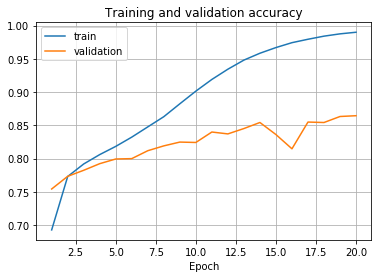

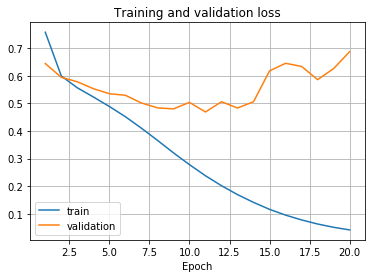

In [230]:
# Plot the accuracy and loss
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
e = np.arange(len(acc)) + 1

plt.plot(e, acc, label = 'train')
plt.plot(e, val_acc, label = 'validation')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.grid()
plt.legend()

plt.figure()

plt.plot(e, loss, label = 'train')
plt.plot(e, val_loss, label = 'validation')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.grid()
plt.legend()

plt.show()

## Test Run

In [231]:
# fresh model, full training set - no validation split, early stopping at 17 epochs
model = build_model()
history = model.fit(data, labels, epochs=17, batch_size=128)

Train on 161297 samples
Epoch 1/17
161297/161297 [==============================] - 37s 229us/sample - loss: 0.7248 - acc: 0.7096
Epoch 2/17
161297/161297 [==============================] - 37s 230us/sample - loss: 0.5794 - acc: 0.7804
Epoch 3/17
161297/161297 [==============================] - 37s 229us/sample - loss: 0.5329 - acc: 0.8009
Epoch 4/17
161297/161297 [==============================] - 37s 227us/sample - loss: 0.4901 - acc: 0.8175
Epoch 5/17
161297/161297 [==============================] - 38s 233us/sample - loss: 0.4435 - acc: 0.8343
Epoch 6/17
161297/161297 [==============================] - 37s 227us/sample - loss: 0.3933 - acc: 0.8535
Epoch 7/17
161297/161297 [==============================] - 37s 232us/sample - loss: 0.3426 - acc: 0.8742
Epoch 8/17
161297/161297 [==============================] - 37s 232us/sample - loss: 0.2932 - acc: 0.8946
Epoch 9/17
161297/161297 [==============================] - 37s 228us/sample - loss: 0.2478 - acc: 0.9143
Epoch 10/17
161297/161

In [232]:
# test predictions for final evaluation
y_pred = np.argmax(model.predict(data_test), axis = 1)
y_true = np.argmax(labels_test, axis = 1)

## Metrics and Results

In [233]:
target_names = ['negative', 'neutral', 'positive']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.84      0.88      0.86     13497
     neutral       0.61      0.64      0.62      4829
    positive       0.95      0.92      0.93     35440

    accuracy                           0.89     53766
   macro avg       0.80      0.81      0.80     53766
weighted avg       0.89      0.89      0.89     53766



89 % accuracy is not bad. Gräßer, Kallumadi, et al. got to 92.24 %, so there is room for improvement. The model is somewhat overfitting, but gives acceptable results on unseen data.

The model is good at detecting positive sentiment, bad at classifying neutral sentiment, and average at classifying negative sentiment.

In [234]:
# Calculate the confusion matrix
print(confusion_matrix(y_true, y_pred).T)

[[11838   877  1442]
 [  673  3113  1349]
 [  986   839 32649]]


In [235]:
# Calculate the cohen's kappa, both with linear and quadratic weights
k = cohen_kappa_score(y_true, y_pred)
print(f"Cohen's kappa (linear)    = {k:.3f}")
k2 = cohen_kappa_score(y_true, y_pred, weights = 'quadratic')
print(f"Cohen's kappa (quadratic) = {k2:.3f}")

Cohen's kappa (linear)    = 0.772
Cohen's kappa (quadratic) = 0.834


Our kappa-values fall short of the 83.99 % achieved by Gräßer, Kallumadi, et al.

## Conclusions

Our model has acceptable performance in detecting the extremes of sentiment, but struggles with the middle ground.

There wasn't time to experiment with all the hyperparameters, like batch size and regularization, so there is still lots of fine tuning to do with potential benefits.